# CCM counter example classification 2

CCM res > CCM EYE >= STD

In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

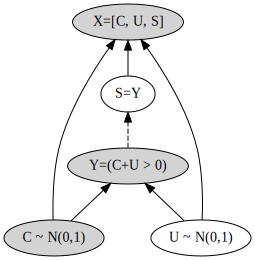

In [2]:
dot = Digraph()

dot.node('Y', 'Y=(C+U > 0)', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('U', 'U ~ N(0,1)')
dot.node('S', 'S=Y')
dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')

dot.edges(['UY', 'CY', 'UX', 'CX', 'SX'])
dot.edge('Y', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example2')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

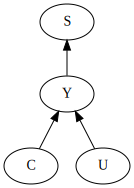

          C         U  S  Y
0 -0.285682  0.214284  0  0
1 -0.216953 -0.962166  0  0
2  2.668256 -1.328445  1  1
3  1.403560  2.178576  1  1
4 -1.081464 -0.106931  0  0
5  0.348930  0.087760  1  1
6  0.419987 -2.122490  0  0
7  0.145217 -0.211660  0  0
8 -1.597281 -0.687266  0  0
9 -1.087599  0.404829  0  0


,C,U,S,Y
0,-1.508554,1.474498,0.0,0
1,0.092050,-1.003158,0.0,0
2,0.077096,2.450790,0.0,1
3,-0.567814,0.965550,0.0,1
4,0.700130,1.905944,0.0,1
5,-0.321265,-2.323297,0.0,0
6,-0.226871,-1.807036,0.0,0
7,-0.444461,-0.139414,0.0,0
8,-0.440054,-1.713974,0.0,0
9,-0.987646,-0.366644,0.0,0


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u = Node('U')
    y  = Node('Y', lambda c, u: (c+u > 0).astype(int),
              [c, u])    
    s = Node('S', lambda y: y, [y])
    
    # initialize the values from data
    graph = Graph([c, u, s, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n)})[['C', 'U', 'S', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

In [4]:
n = 100000
bs = 100
wd = 1e-4


XYC = sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U', 'S']])
    Y = np.array(XYC[['Y']]).ravel()
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 842.76it/s]


epoch   2: loss 3.560e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 684.29it/s]


epoch   5: loss 7.832e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 753.78it/s]


epoch   8: loss 2.467e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 708.02it/s]


epoch  11: loss 1.325e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 678.08it/s]


epoch  14: loss 1.226e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 808.76it/s]


epoch  17: loss 1.223e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 615.41it/s]


epoch  20: loss 1.220e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 902.95it/s]


epoch  23: loss 1.218e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 675.91it/s]


epoch  26: loss 1.221e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 760.77it/s]


epoch  29: loss 1.220e-03


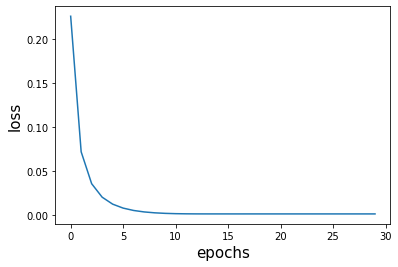

In [5]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 2])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [6]:
# ['C', 'U', 'S']
STD.classifier[0].weight[1] - STD.classifier[0].weight[0]

tensor([3.3454, 3.3606, 9.8150], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 613.40it/s]


epoch   2: loss 8.597e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 627.26it/s]


epoch   5: loss 4.594e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 606.06it/s]


epoch   8: loss 4.218e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 637.04it/s]


epoch  11: loss 4.154e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 535.26it/s]


epoch  14: loss 4.144e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 718.47it/s]


epoch  17: loss 4.143e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 642.69it/s]


epoch  20: loss 4.143e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 748.85it/s]


epoch  23: loss 4.143e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 608.67it/s]


epoch  26: loss 4.144e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 693.77it/s]


epoch  29: loss 4.143e-02


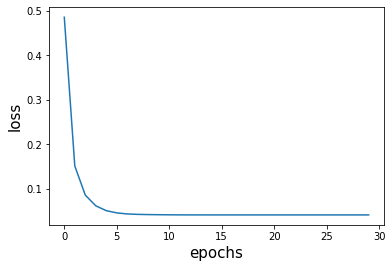

In [7]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 2])

    # train
    # criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.0009 * EYE(r, (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum())
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 30
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [8]:
# ['C', 'U', 'S']
ccm.classifier[0].weight[1] - ccm.classifier[0].weight[0]

tensor([1.9548, 1.4724, 7.1217], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 629.25it/s]


epoch   2: loss 4.998e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 841.90it/s]


epoch   5: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 673.25it/s]


epoch   8: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 655.08it/s]


epoch  11: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 873.74it/s]


epoch  14: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 868.46it/s]


epoch  17: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 837.47it/s]


epoch  20: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 864.94it/s]


epoch  23: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 733.65it/s]


epoch  26: loss 4.997e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 898.59it/s]


epoch  29: loss 4.997e-01


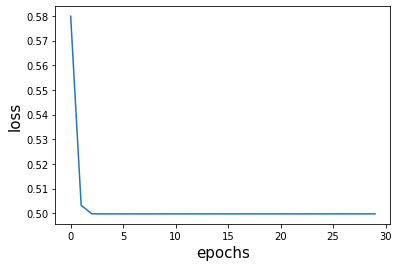

In [9]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 2]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [10]:
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0]

tensor([1.6964], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 742.17it/s]


epoch   2: loss 7.503e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 677.33it/s]


epoch   5: loss 1.658e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 813.44it/s]


epoch   8: loss 4.768e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 797.51it/s]


epoch  11: loss 1.801e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 814.01it/s]


epoch  14: loss 1.230e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 676.61it/s]


epoch  17: loss 1.197e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 842.95it/s]


epoch  20: loss 1.193e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 687.56it/s]


epoch  23: loss 1.193e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 594.17it/s]


epoch  26: loss 1.197e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 575.98it/s]


epoch  29: loss 1.199e-03


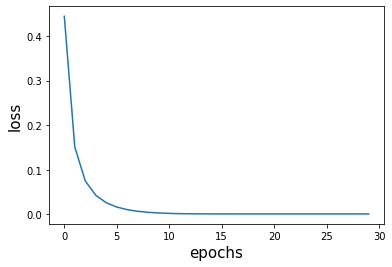

In [11]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 2])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [12]:
res.net2.classifier[0].weight[1] - res.net2.classifier[0].weight[0]

tensor([2.1305, 3.7733, 9.6331], grad_fn=<SubBackward0>)

In [13]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_te, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 990.77it/s]


task acc after training: 100.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1428.52it/s]


task acc after training: 100.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1087.79it/s]


task acc after training: 75.1%


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 959.34it/s]

task acc after training: 100.0%


In [14]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_de, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 975.10it/s]


task acc after training: 69.4%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1445.89it/s]


task acc after training: 57.4%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1359.28it/s]


task acc after training: 75.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1461.25it/s]

task acc after training: 66.1%


# Regression